In [1]:
from google.colab import drive
drive.mount('/content/drive')
#change dir to your project folder
%cd /content/drive/My Drive/Colab Notebooks/kaggle/tweet-sentiment


Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/kaggle/tweet-sentiment


In [2]:
!ls -R
!pip install transformers

.:
'Data_down_tweet sentiment.ipynb'   roberta_whole2.pth
'download_tweet sentiment.ipynb'    roberta_whole.pth
 input				   'TensorFlow roBERTa - [0.712] (1).ipynb'
 roberta_fold1.pth		   'TensorFlow roBERTa - [0.712].ipynb'
 roberta_whole1.pth		    tweet-sentiment-roberta-pytorch.ipynb

./input:
tf-roberta  tweet-sentiment-extraction

./input/tf-roberta:
config-roberta-base.json  pretrained-roberta-base.h5
merges-roberta-base.txt   vocab-roberta-base.json

./input/tweet-sentiment-extraction:
clean_train.csv  error_train.csv  sample_submission.csv  test.csv  train.csv
     |████████████████████████████████| 2.6 MB 8.2 MB/s 
     |████████████████████████████████| 895 kB 51.1 MB/s 
     |████████████████████████████████| 636 kB 50.5 MB/s 
     |████████████████████████████████| 3.3 MB 58.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Libraries

In [3]:
import numpy as np
import pandas as pd
import os
import warnings
from tqdm import tqdm
import random
import torch 
from torch import nn
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import tokenizers
from transformers import RobertaModel, RobertaForQuestionAnswering, RobertaConfig, RobertaTokenizer

warnings.filterwarnings('ignore')

In [4]:
# test out basics of roberta  
# https://huggingface.co/transformers/model_doc/roberta.html#robertaforquestionanswering
Test =False
if Test:
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    text = "Jim is happy, but not me" 
    sent_text = 'negative ' + "Jim is happy, but not me"
    selected_text =  "happy, but not me"

    text = ["I win"]
    selected_text =  "I win"

    inputs = tokenizer(text, return_tensors='pt', pad_to_max_length=True, truncation=True, max_length=10)
    start_positions = torch.tensor([1])
    end_positions = torch.tensor([2])

    model = RobertaForQuestionAnswering.from_pretrained('roberta-base')
    outputs = model(**inputs)
    # outputs = model(**inputs, start_positions=start_positions, end_positions=end_positions)
    loss = outputs.loss
    start_scores = outputs.start_logits
    end_scores = outputs.end_logits
    print(inputs, '\n', outputs)
# outputs
# tokenizer.encode('negative'+"Jim is happy, but not me", return_tensors='pt')
# inputs
# outputs.start_logits.squeeze(0)

# Seed

In [5]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed = 42
seed_everything(seed)

# Data Loader

### Add  token_len, start_idx, end_idx to training data


In [6]:
cleaned = True
if cleaned:
    train_df = pd.read_csv('input/tweet-sentiment-extraction/clean_train.csv')
else:
    train_df = pd.read_csv('input/tweet-sentiment-extraction/train.csv')
train_df['text'] = train_df['text'].astype(str)
train_df['selected_text'] = train_df['selected_text'].astype(str)

In [7]:
if 'token_len' not in train_df:  
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    def token_length(row):
        texto = " " + " ".join(row.text.lower().split())
        text = tokenizer(texto)['input_ids']
        return len(text)
    train_df['token_len'] = train_df.apply(token_length, axis=1)
    print('max train token length: ', train_df.token_len.max())

In [8]:
if 'start_idx' not in train_df:   
    # token level index 
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    def find_idx(row, p_token=False):
        # tokenizer should not use padding since actual length is used
        texto = " " + " ".join(row.text.lower().split())
        sel_to = " " + " ".join(row.selected_text.lower().split())
        text = tokenizer(texto)['input_ids']
        sel_t = tokenizer(sel_to)['input_ids']
        if p_token:
            print(text, '\n', sel_t)
        # for very long sublist finding 
        # see https://stackoverflow.com/questions/7100242/python-numpy-first-occurrence-of-subarray
        # we will just use rolling windows for tweet data
        i = 1
        while i<=len(text)-len(sel_t)+1:
            if text[i] == sel_t[1]:
                # print(i, text[i:i+len(sel_t)-2], sel_t[1:len(sel_t)-1])
                if text[i:i+len(sel_t)-2] == sel_t[1:len(sel_t)-1]:
                    start_idx = i
                    end_idx = i+len(sel_t)-3
                    return start_idx, end_idx
                
            i+=1
        # Error in selected_text, this should be corrected using character level index
        # idea 1: remove incomplete words in selected_text
        # idea 2: complete the words
        # idea 3: remove these rows
        return 0, 0 
     
    train_df['start_idx'] = train_df.apply(lambda x: find_idx(x)[0], axis=1)
    train_df['end_idx'] = train_df.apply(lambda x: find_idx(x)[1], axis=1)

#=============================================================
# character level index
# def find_start(row):
#     return row.text.find(row.selected_text)
# def find_end(row):
#     return  row.start_idx + len(row.selected_text)
# if 'start_idx' not in train_df:
#     train_df['start_idx'] = train_df.apply(lambda row: row.text.find(row.selected_text), axis=1)  # along column
#     train_df['end_idx'] = train_df.apply(find_end, axis=1)



### **Error in training labels** 
?? **convert_tokens_to_string** might solve the subwords error ??

In [9]:
Test =False
if Test:
    error_train_df = train_df[train_df.start_idx ==0]
    error_train_df
# error_train_df.to_csv('input/tweet-sentiment-extraction/error_train.csv')
    print(error_train_df.iloc[0].text, '\n', error_train_df.iloc[0].selected_text)
    find_idx(error_train_df.iloc[0], p_token=True)
    print('**----- selected text wrong -----**')


    print(error_train_df.iloc[2593].text, '\n', error_train_df.iloc[2593].selected_text)
    find_idx(error_train_df.iloc[2593], p_token=True)
    print('**----- selected text missing a parenthesis -----**')

- The error data is droped because
* the error is not a structured and there is no easy fix
* drop 2594/27481 <10% is not hurting too much

In [10]:
train_df_clean = train_df[train_df.start_idx !=0]
train_df_clean.reset_index(drop=True, inplace=True)
del train_df

### Torch data class

In [11]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, df, max_len=96):
        self.df = df
        self.max_len = max_len
        self.labeled = 'selected_text' in df
        self.tokenizer = RobertaTokenizer.from_pretrained("roberta-base")            


    def __getitem__(self, index):
        row = self.df.iloc[index]
        # tokenizer should not use padding since actual length is used
        text_o =  " " + " ".join((row.text + ' '+ row.sentiment).lower().split())
        data = self.tokenizer(text_o, 
                         return_tensors='pt', 
                         pad_to_max_length=True, 
                         truncation=True, 
                         max_length=self.max_len)
        # 
        # since return_tensors='pt' will produce batched result but
        # dataloaders only feed in one row at a time. so we should remove 
        # batch dimension In order to have auto batching working properly
        for key in data.keys():
            data[key]= data[key].squeeze()

        # if we do not require  return_tensors='pt', tokenizer produce list; we need
        #for key in data.keys():
        #    data[key] = torch.tensor(data[key]) 
        
        if self.labeled:
            data['token_len'] = row.token_len
            data['start_idx'] = row.start_idx
            data['end_idx'] = row.end_idx

            """
            compute start_idx and end_idx is time consuming, so we move it 
            to operate after loading df, and saving as columns in df
            """
            # ## old code
            # sel_o = " " + " ".join(row.selected_text.lower().split())
            # sel_token = self.tokenizer(sel_o, 
            #             truncation=True, 
            #             max_length=self.max_len)['input_ids']
            # print(sel_o, '\n', sel_token)
            # data['start_idx'], data['end_idx'] = self.find_idx(text_token, sel_token)
           
        return data
    # def find_idx(self, text, sel_t):
    #   # for very long sublist finding 
    #     # see https://stackoverflow.com/questions/7100242/python-numpy-first-occurrence-of-subarray
    #     # we will just use rolling windows for tweet data
    #     i = 1
    #     while i<=len(text)-len(sel_t)+1:
    #         if text[i] == sel_t[1]:
    #             if text[i:i+len(sel_t)-2]== sel_t[1:len(sel_t)-1]:
    #                 start_idx = i
    #                 print(i)
    #                 end_idx = i+len(sel_t)-3
    #                 return start_idx, end_idx
    #         i+=1
    
    def __len__(self):
        return len(self.df)

#==============================================================  
# auto batching is tricky when data are in different format, we could write a
# function to replace default collate_fn
def customer_batch(data):
    pass

#==============================================================    
        
def get_train_val_loaders(df, train_idx, val_idx, batch_size=8):
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_loader = torch.utils.data.DataLoader(
        TweetDataset(train_df), 
        batch_size=batch_size, 
        #collate_fn= customer_batch,
        shuffle=True, 
        num_workers=1,
        drop_last=True)

    val_loader = torch.utils.data.DataLoader(
        TweetDataset(val_df), 
        batch_size=batch_size, 
        #collate_fn= customer_batch,
        shuffle=False, 
        num_workers=1)

    dataloaders_dict = {"train": train_loader, "val": val_loader}

    return dataloaders_dict

#==============================================================    

def get_test_loader(df, batch_size=32):
    loader = torch.utils.data.DataLoader(
        TweetDataset(df), 
        batch_size=batch_size, 
        #collate_fn= customer_batch,
        shuffle=False, 
        num_workers=1)    
    return loader

In [12]:
"""Test the dataloaders
"""
Test = True
i=1
if Test:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=777*32, random_state=seed)
    for train_idx, val_idx in sss.split(train_df_clean, train_df_clean.sentiment):
        # print(train_idx, val_idx)
        
        data_loader = get_train_val_loaders(train_df_clean, train_idx, val_idx, batch_size=2)['train']
        for data in data_loader:
            if i < 2:
                #print(data)
                i += 1
                
            # decode convert token ids to text
            tokenizer = RobertaTokenizer.from_pretrained("roberta-base")  
            print( tokenizer.decode(data['input_ids'][0][1:5]) )
            break



 like double posting on


In [13]:
train_df_clean

,Unnamed: 0,textID,text,selected_text,sentiment,token_len,start_idx,end_idx
0,0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,12,1,10
1,1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,15,1,3
2,2,088c60f138,my boss is bullying me...,bullying me,negative,8,4,5
3,3,9642c003ef,what interview! leave me alone,leave me alone,negative,8,4,6
4,4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,19,1,4
...,...,...,...,...,...,...,...,...
24882,24882,8f5adc47ec,http://twitpic.com/663vr - Wanted to visit the...,were too late,negative,23,19,21
24883,24883,a208770a32,in spoke to you yesterday and u didnt respond...,in spoke to you yesterday and u didnt respond ...,neutral,16,1,14
24884,24884,b78ec00df5,enjoy ur night,enjoy,positive,5,1,1
24885,24885,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,28,1,8


In [14]:
24887/32

777.71875

# Model

In [15]:
class TweetModel(nn.Module):
    def __init__(self):
        super(TweetModel, self).__init__()
  
        self.roberta = RobertaForQuestionAnswering.from_pretrained('roberta-base')
        # self.dropout = nn.Dropout(0.2)
        # self.fc = nn.Linear(config.hidden_size, 2)
        # nn.init.normal_(self.fc.weight, std=0.02)
        # nn.init.normal_(self.fc.bias, 0)

    def forward(self, inputs):
        outputs = self.roberta(**inputs)
         
        # x = torch.stack([hs[-1], hs[-2], hs[-3], hs[-4]])
        # x = torch.mean(x, 0)
        # x = self.dropout(x)
        # x = self.fc(x)
        # start_logits, end_logits = x.split(1, dim=-1)
        # start_logits = start_logits.squeeze(-1)
        # end_logits = end_logits.squeeze(-1)
                
        return outputs.start_logits, outputs.end_logits


# Loss Function

In [16]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    ce_loss = nn.CrossEntropyLoss()
    # start_logits/end_logits has dimension: batch * text_length
    # start_positions/end_positions : batch * 1
    start_loss = ce_loss(start_logits, start_positions)
    end_loss = ce_loss(end_logits, end_positions)    
    total_loss = start_loss + end_loss
    return total_loss

def loss_fn1(start_logits, end_logits, start_positions, end_positions):
    ce_loss = nn.CrossEntropyLoss()
    # start_logits/end_logits has dimension: batch * text_length
    # start_positions/end_positions : batch * 1
    start_loss = ce_loss(start_logits, start_positions)
    end_loss = ce_loss(end_logits, end_positions)   
    length =  (end_positions - start_positions).abs().float()
    # when length is large, we do not really care so much on every position, take average 
    total_loss = (start_loss + end_loss)/length # + 0.1* length
    return total_loss

- Jaccard distance and Binary Cross Entropy are similar

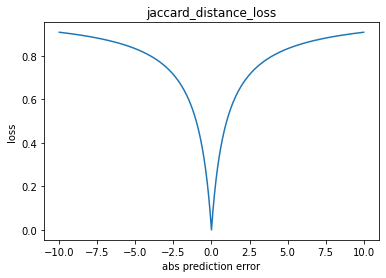

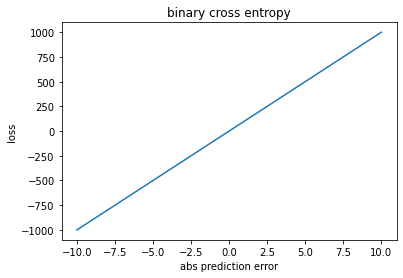

TYPE                 |Almost_right |half right |extra selected |all_wrong
jaccard_distance_loss [0.05 0.45 0.5  0.75]
jaccard_distance_loss scaled [0.06666667 0.6        0.66666667 1.        ]
binary_crossentropy [  3.33333333  30.          66.66666667 100.        ]
binary_crossentropy_scaled [0.03333333 0.3        0.66666667 1.        ]


In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def jaccard_distance_loss(y_true, y_pred, smooth=1):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    Jaccard_smoothed = 
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    """
    intersection= (y_true * y_pred).abs().sum(dim=1)
    union = torch.sum(y_true.abs() + y_pred.abs(), dim=1) -intersection
    jac = (intersection + smooth) / (union + smooth)
    return (1 - jac) * smooth


# Test and plot
y_pred = torch.from_numpy(np.array([np.arange(-10, 10+0.1, 0.1)]).T)
y_true = torch.from_numpy(np.zeros(y_pred.shape))
name='jaccard_distance_loss'
loss = jaccard_distance_loss(y_true,y_pred).numpy()
plt.title(name)
plt.plot(y_pred.numpy(),loss)
plt.xlabel('abs prediction error')
plt.ylabel('loss')
plt.show()
    
name='binary cross entropy'
loss = torch.nn.functional.binary_cross_entropy(
       y_true,y_pred, reduction='none').mean(-1).numpy()
plt.title(name)
plt.plot(y_pred.numpy(),loss)
plt.xlabel('abs prediction error')
plt.ylabel('loss')
plt.show()
    
# Test
print("TYPE                 |Almost_right |half right |extra selected |all_wrong")
y_true = torch.from_numpy(np.array([[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,0,1.,0.]]))
y_pred = torch.from_numpy(np.array([[0,0,0.9,0],[0,0,0.1,0],[1,1,1,1],[1,1,0,1]]))

y_true = torch.from_numpy(np.array([[0,0,1],[0,0,1],[0,0,1],[0,0,1.]]))
y_pred = torch.from_numpy(np.array([[0,0,0.9],[0,0,0.1],[1,1,1],[1,1,0]]))
r1 = jaccard_distance_loss(
    y_true,
    y_pred,).numpy()
print('jaccard_distance_loss',r1)
print('jaccard_distance_loss scaled',r1/r1.max())
assert r1[0]<r1[1]
assert r1[1]<r1[2]

r2 = torch.nn.functional.binary_cross_entropy(
    y_true,
    y_pred,
    reduction='none').mean(-1).numpy()
print('binary_crossentropy',r2)
print('binary_crossentropy_scaled',r2/r2.max())
assert r2[0]<r2[1]
assert r2[1]<r2[2]


# Evaluation Function

- If start_idx pred > end_idx pred: we will take the entire text as selected_text

In [18]:
def jaccard_score(text_token_nopadding_len, start_idx, end_idx, start_pred, end_pred):
    # start_logits, end_logits are logits output of model
    # start_pred = np.argmax(start_logits)
    # end_pred = np.argmax(end_logits)
    text_len = text_token_nopadding_len
    if start_pred > end_pred: # taking the whole text as selected_text
        start_pred = 1
        end_pred = text_len-1

    if end_idx < start_pred or end_pred < start_idx: # intersection = 0
        return 0
    else: 
        union = max(end_pred, end_idx) - min(start_pred, start_idx)+1
        intersection = min(end_pred, end_idx) - max(start_pred, start_idx)+1
        return intersection/union
Test =False
if Test:
    jaccard_score(5,1,1,4,2) # 0.25
    # jaccard_score(96,1,1,4,2) # 0.0105

    start_logits = torch.tensor([[0,0,0,0,1]]).float() 
    start_idx =torch.tensor([1])
    #start_pred = torch.cat((start_pred, torch.zeros(1,91)),axis=1)

    ce = torch.nn.CrossEntropyLoss()
    ce(start_logits, start_idx)
# when len=5, loss = 1.9048; when len=96, loss = 4.5718


- **Note**: 
1. jaccard_score is sensitive to total length, CrossEntropy is not sensitive.
2. our jaccard_score function is a fast and close approximation of the true Jaccard score (character level) used in this competetion. There would be a bit more computation if we want character level Jaccard.

# Training Function

In [19]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, batch_size, filename):
    if torch.cuda.is_available():
        model.cuda()

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_jaccard = 0.0
            
            with tqdm(dataloaders_dict[phase], unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                for data in tepoch:
                    # reserve token_len, start_idx, end_idx for later loss computation
                    token_len = data['token_len'].numpy()
                    start_idx = data['start_idx']
                    end_idx = data['end_idx']
                    for key in ['token_len', 'start_idx', 'end_idx']:
                        data.pop(key)
                    
                    # put data in GPU
                    if torch.cuda.is_available():
                        start_idx = start_idx.cuda()
                        end_idx = end_idx.cuda()
                        for key in data.keys():
                            data[key]= data[key].cuda()

                    # training 
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):

                        start_logits, end_logits = model.forward(data)

                        loss = criterion(start_logits, end_logits, start_idx, end_idx)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        epoch_loss += loss.item() 
                        
                        # Jaccard score
                        #torch.argmax(torch.tensor([[0,0,0,0,1],[0,0,0,1.5,1]]), dim=1)
                        start_pred = torch.argmax(start_logits, dim=1).cpu().detach().numpy()
                        end_pred = torch.argmax(end_logits, dim=1).cpu().detach().numpy()
                        
                        start_idx = start_idx.cpu().detach().numpy()
                        end_idx = end_idx.cpu().detach().numpy()

                        for i in range(batch_size):  # or range(token_len.shape[0])                      
                            jaccard = jaccard_score(token_len[i], start_idx[i], end_idx[i], start_pred[i], end_pred[i])
                            epoch_jaccard += jaccard
                    tepoch.set_postfix(loss=loss.item()/batch_size)
                    
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_jaccard = epoch_jaccard / len(dataloaders_dict[phase].dataset)
            
            print('Epoch {}/{} | {:^5} | Loss: {:.4f} | Jaccard: {:.4f}'.format(
                epoch + 1, num_epochs, phase, epoch_loss, epoch_jaccard))
    
    torch.save(model.state_dict(), filename)

# Training

In [18]:
num_epochs = 5
batch_size = 32
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)


In [19]:
torch.cuda.empty_cache() 

In [20]:
%%time
# Each fold takes 7* epochs = 35 mins,
split_fold = False
if split_fold:
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df_clean, train_df_clean.sentiment), start=1): 

        print(f'Fold: {fold}')

        model = TweetModel()
        optimizer = optim.AdamW(model.parameters(), lr=3e-5, betas=(0.9, 0.999))
        criterion = loss_fn    
        dataloaders_dict = get_train_val_loaders(train_df_clean, train_idx, val_idx, batch_size)
        train_model(
            model, 
            dataloaders_dict,
            criterion, 
            optimizer, 
            num_epochs,
            batch_size,
            f'roberta_fold{fold}.pth')

Fold: 1


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/5 | train | Loss: 0.0574 | Jaccard: 0.6905


Epoch 1:   0%|          | 0/622 [00:00<?, ?batch/s]

Epoch 1/5 |  val  | Loss: 0.0432 | Jaccard: 0.7367


Epoch 1:   0%|          | 0/155 [00:00<?, ?batch/s]

Epoch 2/5 | train | Loss: 0.0412 | Jaccard: 0.7466


Epoch 2:   0%|          | 0/622 [00:00<?, ?batch/s]

Epoch 2/5 |  val  | Loss: 0.0408 | Jaccard: 0.7456


Epoch 2:   0%|          | 0/155 [00:00<?, ?batch/s]

Epoch 3/5 | train | Loss: 0.0368 | Jaccard: 0.7646


Epoch 3:   0%|          | 0/622 [00:00<?, ?batch/s]

Epoch 3/5 |  val  | Loss: 0.0427 | Jaccard: 0.7329


Epoch 3:   0%|          | 0/155 [00:00<?, ?batch/s]

Epoch 4/5 | train | Loss: 0.0325 | Jaccard: 0.7884


Epoch 4:   0%|          | 0/622 [00:00<?, ?batch/s]

Epoch 4/5 |  val  | Loss: 0.0460 | Jaccard: 0.7345


Epoch 4:   0%|          | 0/155 [00:00<?, ?batch/s]

Epoch 5/5 | train | Loss: 0.0281 | Jaccard: 0.8128


Epoch 4: 100%|██████████| 155/155 [00:27<00:00,  5.72batch/s, loss=0.0411]


Epoch 5/5 |  val  | Loss: 0.0491 | Jaccard: 0.7370
Fold: 2


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use 

KeyboardInterrupt: ignored

- We see a increase in validation loss after 2 epochs. So we only train 2 epochs on the full data

### run on the full training data

In [27]:
torch.cuda.empty_cache() 

In [21]:
%%time
num_epochs = 2
batch_size = 32
split_fold = False
if not split_fold:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=776*32, random_state=seed)
    for train_idx, val_idx in sss.split(train_df_clean, train_df_clean.sentiment):
        dataloaders_dict = get_train_val_loaders(train_df_clean, train_idx, val_idx, batch_size)

    model = TweetModel()
    optimizer = optim.AdamW(model.parameters(), lr=3e-5, betas=(0.9, 0.999))
    criterion = loss_fn    
    
    train_model(
        model, 
        dataloaders_dict,
        criterion, 
        optimizer, 
        num_epochs,
        batch_size,
        f'roberta_whole.pth')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/2 | train | Loss: 0.0568 | Jaccard: 0.6929


Epoch 1: : 0batch [00:00, ?batch/s]
Epoch 2:   0%|          | 0/777 [00:00<?, ?batch/s]

Epoch 1/2 |  val  | Loss: 0.0000 | Jaccard: 0.0000


Epoch 2: 100%|██████████| 777/777 [07:33<00:00,  1.71batch/s, loss=0.0366]
Epoch 2: : 0batch [00:00, ?batch/s]

Epoch 2/2 | train | Loss: 0.0417 | Jaccard: 0.7438


Epoch 2: : 0batch [00:00, ?batch/s]


Epoch 2/2 |  val  | Loss: 0.0000 | Jaccard: 0.0000
CPU times: user 7min 25s, sys: 7min 38s, total: 15min 4s
Wall time: 15min 31s


In [26]:
del model

In [31]:
# train one more epoch with lower learning rate
sss = StratifiedShuffleSplit(n_splits=1, train_size=775*32, random_state=seed)
for train_idx, val_idx in sss.split(train_df_clean, train_df_clean.sentiment):
    dataloaders_dict = get_train_val_loaders(train_df_clean, train_idx, val_idx, batch_size)
num_epochs = 1
model = TweetModel()
model.cuda()
model.load_state_dict(torch.load(f'/content/drive/MyDrive/Colab Notebooks/kaggle/tweet-sentiment/roberta_whole.pth'))


optimizer = optim.AdamW(model.parameters(), lr=3e-6, betas=(0.9, 0.999)) 

train_model(
    model, 
    dataloaders_dict,
    criterion, 
    optimizer, 
    num_epochs,
    batch_size,
    f'roberta_whole2.pth')

Epoch 1:   0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 1/1 | train | Loss: 0.0360 | Jaccard: 0.7712


Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  4.05batch/s, loss=0.0503]


Epoch 1/1 |  val  | Loss: 0.0341 | Jaccard: 0.5446


# Inference

In [20]:
# For Inference only
# https://huggingface.co/transformers/internal/tokenization_utils.html

test_df = pd.read_csv('input/tweet-sentiment-extraction/test.csv')
test_df['text'] = test_df['text'].astype(str)
test_loader = get_test_loader(test_df)


model = TweetModel()
if torch.cuda.is_available():
    model.cuda()
    model.load_state_dict(torch.load(f'roberta_whole.pth'))
else:
    model.load_state_dict(torch.load(f'roberta_whole.pth', map_location=torch.device('cpu') ))
model.eval()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use 

TweetModel(
  (roberta): RobertaForQuestionAnswering(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_feat

In [21]:
%%time
predictions = []
# decode convert token ids to text
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")  
with tqdm(test_loader, unit="batch") as tepoch:
    tepoch.set_description("Test:")
    for data in tepoch:
        
        # put data in GPU
        if torch.cuda.is_available():
            for key in data.keys():
                data[key]= data[key].cuda()

        # testing 
        with torch.no_grad():

            start_logits, end_logits = model(data)
            start_pred = torch.argmax(start_logits, dim=1)
            end_pred = torch.argmax(end_logits, dim=1)
            
            for i in range(start_pred.shape[0]): # number of rows in a batch
                if start_pred[i] > end_pred[i]:
                    predictions.append(' ') # those will be replace by text after we build the dataframe
                else:
                    sel_t = tokenizer.decode(data['input_ids'][i][start_pred[i]:end_pred[i]+1])
                    predictions.append(sel_t)


Test::   0%|          | 0/111 [00:00<?, ?batch/s]

32


Test::   2%|▏         | 2/111 [00:00<00:42,  2.57batch/s]

32
32


Test::   4%|▎         | 4/111 [00:00<00:29,  3.66batch/s]

32
32


Test::   5%|▌         | 6/111 [00:01<00:22,  4.65batch/s]

32
32


Test::   7%|▋         | 8/111 [00:01<00:19,  5.27batch/s]

32
32


Test::   9%|▉         | 10/111 [00:01<00:17,  5.69batch/s]

32
32


Test::  11%|█         | 12/111 [00:02<00:16,  5.93batch/s]

32
32


Test::  13%|█▎        | 14/111 [00:02<00:15,  6.08batch/s]

32
32


Test::  14%|█▍        | 16/111 [00:02<00:15,  6.14batch/s]

32
32


Test::  16%|█▌        | 18/111 [00:03<00:15,  6.14batch/s]

32
32


Test::  18%|█▊        | 20/111 [00:03<00:14,  6.19batch/s]

32
32


Test::  20%|█▉        | 22/111 [00:03<00:14,  6.17batch/s]

32
32


Test::  22%|██▏       | 24/111 [00:04<00:13,  6.23batch/s]

32
32


Test::  23%|██▎       | 26/111 [00:04<00:13,  6.19batch/s]

32
32


Test::  25%|██▌       | 28/111 [00:04<00:13,  6.21batch/s]

32
32


Test::  27%|██▋       | 30/111 [00:05<00:13,  6.19batch/s]

32
32


Test::  29%|██▉       | 32/111 [00:05<00:12,  6.14batch/s]

32
32


Test::  31%|███       | 34/111 [00:05<00:12,  6.17batch/s]

32
32


Test::  32%|███▏      | 36/111 [00:06<00:12,  6.15batch/s]

32
32


Test::  34%|███▍      | 38/111 [00:06<00:11,  6.13batch/s]

32
32


Test::  36%|███▌      | 40/111 [00:06<00:11,  6.14batch/s]

32
32


Test::  38%|███▊      | 42/111 [00:07<00:11,  6.17batch/s]

32
32


Test::  40%|███▉      | 44/111 [00:07<00:10,  6.13batch/s]

32
32


Test::  41%|████▏     | 46/111 [00:07<00:10,  6.14batch/s]

32
32


Test::  43%|████▎     | 48/111 [00:08<00:10,  6.17batch/s]

32
32


Test::  45%|████▌     | 50/111 [00:08<00:09,  6.15batch/s]

32
32


Test::  47%|████▋     | 52/111 [00:08<00:09,  6.15batch/s]

32
32


Test::  49%|████▊     | 54/111 [00:09<00:09,  6.16batch/s]

32
32


Test::  50%|█████     | 56/111 [00:09<00:08,  6.14batch/s]

32
32


Test::  52%|█████▏    | 58/111 [00:09<00:08,  6.14batch/s]

32
32


Test::  54%|█████▍    | 60/111 [00:10<00:08,  6.10batch/s]

32
32


Test::  56%|█████▌    | 62/111 [00:10<00:08,  6.09batch/s]

32
32


Test::  58%|█████▊    | 64/111 [00:10<00:07,  6.12batch/s]

32
32


Test::  59%|█████▉    | 66/111 [00:11<00:07,  6.06batch/s]

32
32


Test::  61%|██████▏   | 68/111 [00:11<00:07,  6.09batch/s]

32
32


Test::  63%|██████▎   | 70/111 [00:11<00:06,  6.13batch/s]

32
32


Test::  65%|██████▍   | 72/111 [00:12<00:06,  6.10batch/s]

32
32


Test::  67%|██████▋   | 74/111 [00:12<00:06,  6.11batch/s]

32
32


Test::  68%|██████▊   | 76/111 [00:12<00:05,  6.13batch/s]

32
32


Test::  70%|███████   | 78/111 [00:13<00:05,  6.05batch/s]

32
32


Test::  72%|███████▏  | 80/111 [00:13<00:05,  6.08batch/s]

32
32


Test::  74%|███████▍  | 82/111 [00:13<00:04,  6.12batch/s]

32
32


Test::  76%|███████▌  | 84/111 [00:13<00:04,  6.12batch/s]

32
32


Test::  77%|███████▋  | 86/111 [00:14<00:04,  6.06batch/s]

32
32


Test::  79%|███████▉  | 88/111 [00:14<00:03,  6.07batch/s]

32
32


Test::  81%|████████  | 90/111 [00:14<00:03,  6.07batch/s]

32
32


Test::  83%|████████▎ | 92/111 [00:15<00:03,  6.03batch/s]

32
32


Test::  85%|████████▍ | 94/111 [00:15<00:02,  6.00batch/s]

32
32


Test::  86%|████████▋ | 96/111 [00:15<00:02,  6.05batch/s]

32
32


Test::  88%|████████▊ | 98/111 [00:16<00:02,  6.11batch/s]

32
32


Test::  90%|█████████ | 100/111 [00:16<00:01,  6.12batch/s]

32
32


Test::  92%|█████████▏| 102/111 [00:16<00:01,  6.09batch/s]

32
32


Test::  94%|█████████▎| 104/111 [00:17<00:01,  6.07batch/s]

32
32


Test::  95%|█████████▌| 106/111 [00:17<00:00,  6.06batch/s]

32
32


Test::  97%|█████████▋| 108/111 [00:17<00:00,  6.07batch/s]

32
32


Test::  99%|█████████▉| 110/111 [00:18<00:00,  6.11batch/s]

32
14


Test:: 100%|██████████| 111/111 [00:18<00:00,  6.03batch/s]

CPU times: user 17.8 s, sys: 235 ms, total: 18.1 s
Wall time: 21.1 s


# Submission

In [22]:
sub_df = test_df[['textID','text']]
sub_df['selected_text'] = predictions
def rep_text(row):
    rst= row.selected_text
    if (rst is ' ') or (len(rst)> len(row.text)):
        return row.text
    if len(rst.split())==1:
        rst = rst.replace('!!!!', '!')
        rst = rst.replace('..', '.')
        rst = rst.replace('...', '.')
        return rst
    return rst

sub_df['selected_text'] = sub_df.apply(rep_text, axis=1)
sub_df.drop(['text'], axis=1, inplace=True)
sub_df.to_csv('submission.csv', index=False)
sub_df.head()

,textID,selected_text
0,f87dea47db,last session of the day
1,96d74cb729,exciting
2,eee518ae67,such a shame!
3,01082688c6,happy
4,33987a8ee5,i like it!!
